#Compression algorithm using VQ-VAE

In [ ]:
pip install iteration_utilities

     |████████████████████████████████| 286kB 8.2MB/s 


In [ ]:
# Imports.
import numpy as np
from matplotlib import pyplot as plt
import sys
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, fashion_mnist

In [ ]:
from iteration_utilities import deepflatten

##Multivariate

In [ ]:
data_path = 'Metro_Interstate_Traffic_Volume.csv'
traffic = pd.read_csv(data_path)

In [ ]:
traffic = traffic.rename(columns={'date_time': 'ds', 'traffic_volume': 'y'})
y = traffic['y']
ds = traffic['ds']
X = traffic.drop(['holiday','ds', 'weather_main','snow_1h', 'weather_description'], axis = 1)
X

,temp,rain_1h,clouds_all,y
0,288.28,0.0,40,5545
1,289.36,0.0,75,4516
2,289.58,0.0,90,4767
3,290.13,0.0,90,5026
4,291.14,0.0,75,4918
...,...,...,...,...
48199,283.45,0.0,75,3543
48200,282.76,0.0,90,2781
48201,282.73,0.0,90,2159
48202,282.09,0.0,90,1450


In [ ]:
X['rain_1h'] = X['rain_1h'].replace(9831.30,55.63)

In [ ]:
TIME_STEPS = 256

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values.iloc[i : (i + time_steps),:])
    
    return np.stack(output)

train_dataset_m = create_sequences(X)
print("Training input shape: ", train_dataset_m.shape)
x_train_m = train_dataset_m

Training input shape:  (47948, 256, 4)


In [ ]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance

        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss

        return recon_loss + loss #* beta
    return vq_vae_loss

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 128 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))

        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(params=w, ids=encoding_indices)

In [ ]:
def dictionary_encoding(intermediate_output):

  global i
  global j
  i = -1
  j = -1

  encoded_vectors = {}
  for emb_1 in intermediate_output:
    i +=1
    j = -1
    for emb_2 in emb_1:
      j +=1
      emb_2 = tuple(emb_2)
      #print(emb_2)
      if emb_2 in encoded_vectors:

        previous = encoded_vectors[emb_2]
        previous.append((i,j))
        encoded_vectors[emb_2] = previous
      else:
        encoded_vectors[emb_2] = [(i,j)]
  return encoded_vectors

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 21s 505us/sample - loss: 83.4123 - val_loss: 0.3584
Epoch 2/150
41942/41942 [==============================] - 20s 471us/sample - loss: 0.3766 - val_loss: 0.3495
Epoch 3/150
41942/41942 [==============================] - 20s 473us/sample - loss: 0.3565 - val_loss: 0.3491
Epoch 4/150
41942/41942 [==============================] - 20s 471us/sample - loss: 0.3660 - val_loss: 0.3496
Epoch 5/150
41942/41942 [==============================] - 20s 473us/sample - loss: 0.3482 - val_loss: 0.3493
Epoch 6/150
41942/41942 [==============================] - 20s 473us/sample - loss: 0.3501 - val_loss: 0.3493
Epoch 7/150
41942/41942 [==============================] - 20s 474us/sample - loss: 0.3473 - val_loss: 0.3492
Epoch 8/150
41942/41942 [==============================] - 20s 481us/sample - loss: 0.3676 - val_loss: 0.3497


In [ ]:
#4min17s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(46603, 256, 4)

In [ ]:
#4s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.044728
1    5.974361
2    0.074865
3    0.023794
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
intermediate_output[:5]

array([[[0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        ...,
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586]],

       [[0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        ...,
        [0.00126925, 0.00427177, 0.00453922, ..., 0.00109743,
         0.00379641, 0.00174586],
        [0.0

In [ ]:
#7s

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0001653721406623421


In [ ]:
len(encoded_vectors)

1

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 128, 128)          3712      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 64, 64)            57408     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 32, 32)            14368     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 10s 220us/sample - loss: 307.1835 - val_loss: 0.3543
Epoch 2/150
43153/43153 [==============================] - 7s 161us/sample - loss: 0.3705 - val_loss: 0.3471
Epoch 3/150
43153/43153 [==============================] - 7s 159us/sample - loss: 0.3640 - val_loss: 0.3439
Epoch 4/150
43153/43153 [==============================] - 7s 159us/sample - loss: 0.3535 - val_loss: 0.3454
Epoch 5/150
43153/43153 [==============================] - 7s 162us/sample - loss: 0.3470 - val_loss: 0.3436
Epoch 6/150
43153/43153 [==============================] - 7s 159us/sample - loss: 0.3485 - val_loss: 0.3445
Epoch 7/150
43153/43153 [==============================] - 7s 157us/sample - loss: 0.3483 - val_loss: 0.3442
Epoch 8/150
43153/43153 [==============================] - 7s 160us/sample - loss: 0.3462 - val_loss: 0.3451
Epoch 9/150
43153/43153 [==============================] - 7s 160us/sample -

In [ ]:
#4min33s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(47948, 256, 4)

In [ ]:
#7s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.005740
1    0.912299
2    0.003395
3    0.009149
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
#5s

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 128, 64)           1856      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 64, 32)            14368     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64, 32)            0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 64, 32)            1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 64, 32)            1024

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 12s 277us/sample - loss: 1930.6388 - val_loss: 0.3637
Epoch 2/150
43153/43153 [==============================] - 9s 208us/sample - loss: 0.3703 - val_loss: 0.3526
Epoch 3/150
43153/43153 [==============================] - 9s 209us/sample - loss: 0.3571 - val_loss: 0.3475
Epoch 4/150
43153/43153 [==============================] - 9s 209us/sample - loss: 0.3669 - val_loss: 0.3469
Epoch 5/150
43153/43153 [==============================] - 9s 207us/sample - loss: 0.3537 - val_loss: 0.3468
Epoch 6/150
43153/43153 [==============================] - 9s 216us/sample - loss: 0.3511 - val_loss: 0.3450
Epoch 7/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3527 - val_loss: 0.3457
Epoch 8/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3495 - val_loss: 0.3454
Epoch 9/150
43153/43153 [==============================] - 9s 220us/sample 

In [ ]:
#2min14s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(47948, 256, 4)

In [ ]:
#5s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.010747
1    4.071810
2    0.082473
3    0.114070
dtype: float64

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_37 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           1024      
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 64, 16)            360

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 11s 250us/sample - loss: 16049.5022 - val_loss: 44.0800
Epoch 2/150
43153/43153 [==============================] - 8s 178us/sample - loss: 72.0506 - val_loss: 8.4347
Epoch 3/150
43153/43153 [==============================] - 8s 178us/sample - loss: 24.4005 - val_loss: 3.6295
Epoch 4/150
43153/43153 [==============================] - 8s 179us/sample - loss: 12.1929 - val_loss: 2.3440
Epoch 5/150
43153/43153 [==============================] - 8s 177us/sample - loss: 7.0999 - val_loss: 1.4406
Epoch 6/150
43153/43153 [==============================] - 8s 177us/sample - loss: 4.5384 - val_loss: 0.9107
Epoch 7/150
43153/43153 [==============================] - 8s 182us/sample - loss: 2.8922 - val_loss: 0.5837
Epoch 8/150
43153/43153 [==============================] - 8s 183us/sample - loss: 1.8583 - val_loss: 0.3450
Epoch 9/150
43153/43153 [==============================] - 8s 183us/sa

In [ ]:
#1m54s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(47948, 256, 4)

In [ ]:
#5s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0     0.466827
1    11.120696
2     0.441062
3     0.368381
dtype: float64

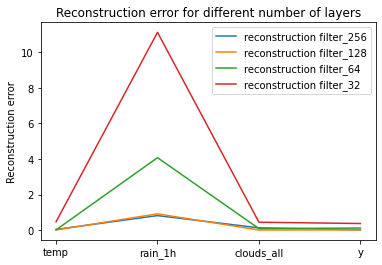

In [ ]:
# dimension of embeddings =  32
# number of embeddings = 32
l_256 = [0.036477, 0.813709, 0.125471, 0.013706]
l_128 = [0.005740, 0.912299, 0.003395, 0.009149]
l_64 = [0.010747, 4.071810, 0.082473, 0.114070]
l_32 = [0.466827, 11.120696, 0.441062, 0.368381]

ts = ['temp',	'rain_1h',	'clouds_all',	'y']
plt.plot( ts,l_256, label = 'reconstruction filter_256')
plt.plot(ts,l_128, label = 'reconstruction filter_128')
plt.plot(ts,l_64, label = 'reconstruction filter_64')
plt.plot(ts,l_32, label = 'reconstruction filter_32')
plt.title('Reconstruction error for different number of layers')
plt.ylabel('Reconstruction error')
plt.legend()
plt.show()

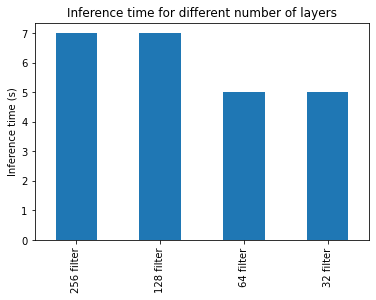

In [ ]:
# dimension of embeddings =  32
# number of embeddings = 32

time = [7, 7, 5, 5]
layers = ['256 filter','128 filter' , '64 filter', '32 filter']
df_error = pd.DataFrame(time, index = layers)
df_error.plot(kind = 'bar', legend = False)
plt.title('Inference time for different number of layers')
plt.ylabel('Inference time (s)')
#plt.legend()
plt.show()

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 128, 128)          3712      
_________________________________________________________________
dropout_53 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 64, 64)            57408     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 32, 32)            14368     
_________________________________________________________________
dropout_55 (Dropout)         (None, 32, 32)            0  

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 18s 424us/sample - loss: 275.4907 - val_loss: 0.3919
Epoch 2/150
43153/43153 [==============================] - 14s 334us/sample - loss: 0.3879 - val_loss: 0.3611
Epoch 3/150
43153/43153 [==============================] - 14s 332us/sample - loss: 0.3649 - val_loss: 0.3513
Epoch 4/150
43153/43153 [==============================] - 14s 326us/sample - loss: 0.3546 - val_loss: 0.3512
Epoch 5/150
43153/43153 [==============================] - 14s 327us/sample - loss: 0.3550 - val_loss: 0.3474
Epoch 6/150
43153/43153 [==============================] - 14s 324us/sample - loss: 0.3550 - val_loss: 0.3450
Epoch 7/150
43153/43153 [==============================] - 14s 323us/sample - loss: 0.3535 - val_loss: 0.4382
Epoch 8/150
43153/43153 [==============================] - 14s 322us/sample - loss: 0.3735 - val_loss: 0.3579
Epoch 9/150
43153/43153 [==============================] - 14s 323us/

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.089364
1    2.772716
2    0.105009
3    0.204751
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 128, 128)          3712      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 64, 64)            57408     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 64, 8)             520       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 64, 8)             512 

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 13s 314us/sample - loss: 740.4720 - val_loss: 0.3567
Epoch 2/150
41942/41942 [==============================] - 12s 280us/sample - loss: 0.8521 - val_loss: 0.5929
Epoch 3/150
41942/41942 [==============================] - 12s 280us/sample - loss: 0.5438 - val_loss: 0.3514
Epoch 4/150
41942/41942 [==============================] - 12s 278us/sample - loss: 0.3638 - val_loss: 0.3550
Epoch 5/150
41942/41942 [==============================] - 12s 279us/sample - loss: 0.3616 - val_loss: 0.3543
Epoch 6/150
41942/41942 [==============================] - 12s 278us/sample - loss: 0.3530 - val_loss: 0.3522
Epoch 7/150
41942/41942 [==============================] - 12s 279us/sample - loss: 0.3543 - val_loss: 0.3532
Epoch 8/150
41942/41942 [==============================] - 12s 285us/sample - loss: 0.3628 - val_loss: 0.3528


In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.542463
1    0.938420
2    0.392212
3    0.586181
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

46603

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.00025072550358484124


In [ ]:
#algorithm
def VAE_compression(reconstruction_error):
  # number of layers - determined by filters (embedding size<=f<=batchsize)( where f = 2^x)
  # embedding size (8<=e_s<=batch_size/4)(where e_s = 2^y) 
  # number of embeddings (8<=n_e<=batch_size)(where n_s = 2^z)

## Compression vs Reconstruction error

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 128 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 22s 529us/sample - loss: 96.2156 - val_loss: 0.3574
Epoch 2/150
41942/41942 [==============================] - 20s 482us/sample - loss: 0.3510 - val_loss: 0.3493
Epoch 3/150
41942/41942 [==============================] - 20s 483us/sample - loss: 0.3480 - val_loss: 0.3498
Epoch 4/150
41942/41942 [==============================] - 20s 485us/sample - loss: 0.3464 - val_loss: 0.3510
Epoch 5/150
41942/41942 [==============================] - 20s 481us/sample - loss: 0.3466 - val_loss: 0.3491
Epoch 6/150
41942/41942 [==============================] - 20s 482us/sample - loss: 0.3462 - val_loss: 0.3491
Epoch 7/150
41942/41942 [==============================] - 20s 482us/sample - loss: 0.3462 - val_loss: 0.3512
Epoch 8/150
41942/41942 [==============================] - 20s 487us/sample - loss: 0.3463 - val_loss: 0.3499
Epoch 9/150
41942/41942 [==============================] - 20s 482us/s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0     0.032258
1    13.136164
2     0.023639
3     0.001509
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

46603

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0001653721406623421


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_18 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 22s 535us/sample - loss: 135.1052 - val_loss: 0.3567
Epoch 2/150
41942/41942 [==============================] - 20s 481us/sample - loss: 0.3564 - val_loss: 0.3494
Epoch 3/150
41942/41942 [==============================] - 20s 487us/sample - loss: 0.3494 - val_loss: 0.3491
Epoch 4/150
41942/41942 [==============================] - 20s 483us/sample - loss: 0.3540 - val_loss: 0.3501
Epoch 5/150
41942/41942 [==============================] - 20s 480us/sample - loss: 0.3491 - val_loss: 0.3503
Epoch 6/150
41942/41942 [==============================] - 20s 488us/sample - loss: 0.3475 - val_loss: 0.3494
Epoch 7/150
41942/41942 [==============================] - 20s 485us/sample - loss: 0.3483 - val_loss: 0.3493
Epoch 8/150
41942/41942 [==============================] - 21s 492us/sample - loss: 0.3465 - val_loss: 0.3510


In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.026194
1    0.708032
2    0.048497
3    0.026201
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

46603

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0001653721406623421


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_22 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_23 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 64)            0  

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 23s 543us/sample - loss: 122.5042 - val_loss: 0.3592
Epoch 2/150
41942/41942 [==============================] - 20s 487us/sample - loss: 0.3635 - val_loss: 0.3511
Epoch 3/150
41942/41942 [==============================] - 20s 482us/sample - loss: 0.3511 - val_loss: 0.3495
Epoch 4/150
41942/41942 [==============================] - 20s 482us/sample - loss: 0.3490 - val_loss: 0.3491
Epoch 5/150
41942/41942 [==============================] - 20s 489us/sample - loss: 0.3481 - val_loss: 0.3496
Epoch 6/150
41942/41942 [==============================] - 20s 483us/sample - loss: 1083.0620 - val_loss: 0.4271
Epoch 7/150
41942/41942 [==============================] - 20s 481us/sample - loss: 0.3766 - val_loss: 0.3498
Epoch 8/150
41942/41942 [==============================] - 20s 484us/sample - loss: 0.3508 - val_loss: 0.3496
Epoch 9/150
41942/41942 [==============================] - 21s 498

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.002896
1    1.241386
2    0.106890
3    0.012251
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

46603

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0001653721406623421


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_27 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_29 (Dropout)         (None, 32, 64)            0  

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 41942 samples, validate on 4661 samples
Epoch 1/150
41942/41942 [==============================] - 24s 569us/sample - loss: 243.6231 - val_loss: 0.3587
Epoch 2/150
41942/41942 [==============================] - 21s 490us/sample - loss: 0.3551 - val_loss: 0.3506
Epoch 3/150
41942/41942 [==============================] - 20s 485us/sample - loss: 0.3499 - val_loss: 0.3492
Epoch 4/150
41942/41942 [==============================] - 21s 492us/sample - loss: 0.3483 - val_loss: 0.3504
Epoch 5/150
41942/41942 [==============================] - 21s 492us/sample - loss: 0.3469 - val_loss: 0.3491
Epoch 6/150
41942/41942 [==============================] - 21s 489us/sample - loss: 0.3465 - val_loss: 0.3493
Epoch 7/150
41942/41942 [==============================] - 21s 493us/sample - loss: 0.3483 - val_loss: 0.3498
Epoch 8/150
41942/41942 [==============================] - 21s 497us/sample - loss: 0.3469 - val_loss: 0.3491
Epoch 9/150
41942/41942 [==============================] - 20s 489us/

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.026444
1    4.130036
2    0.021825
3    0.001149
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

46603

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0001653721406623421


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 8 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 256)          7424      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 64, 128)           229504    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 64)            57408     
_________

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 24s 554us/sample - loss: 504.5848 - val_loss: 0.3835
Epoch 2/150
43153/43153 [==============================] - 7s 151us/sample - loss: 0.5581 - val_loss: 0.3619
Epoch 3/150
43153/43153 [==============================] - 7s 151us/sample - loss: 0.4303 - val_loss: 0.3558
Epoch 4/150
43153/43153 [==============================] - 7s 152us/sample - loss: 0.3972 - val_loss: 0.3520
Epoch 5/150
43153/43153 [==============================] - 6s 149us/sample - loss: 0.3781 - val_loss: 0.3485
Epoch 6/150
43153/43153 [==============================] - 6s 148us/sample - loss: 0.3711 - val_loss: 0.3445
Epoch 7/150
43153/43153 [==============================] - 6s 146us/sample - loss: 0.3608 - val_loss: 0.3440
Epoch 8/150
43153/43153 [==============================] - 6s 147us/sample - loss: 0.3584 -

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.038827
1    2.147787
2    0.002935
3    0.028358
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
intermediate_output[:5]

array([[[ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.02089264, -0.01841591, -0.01517165,  0.00266449,
         -0.00227766, -0.00397374, -0.0054285 , -0.02177853],
        [ 0.0208

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
len(encoded_vectors)

1

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 256)          7424      
_________________________________________________________________
dropout (Dropout)            (None, 128, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           229504    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 128)           0         
____________________________________________________________

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 26s 608us/sample - loss: 136.6061 - val_loss: 0.3507
Epoch 2/150
43153/43153 [==============================] - 9s 215us/sample - loss: 0.3891 - val_loss: 0.3435
Epoch 3/150
43153/43153 [==============================] - 9s 213us/sample - loss: 0.3737 - val_loss: 0.3440
Epoch 4/150
43153/43153 [==============================] - 9s 214us/sample - loss: 0.3541 - val_loss: 0.3434
Epoch 5/150
43153/43153 [==============================] - 9s 215us/sample - loss: 0.3597 - val_loss: 0.3451
Epoch 6/150
43153/43153 [==============================] - 9s 216us/sample - loss: 0.3507 - val_loss: 0.3474
Epoch 7/150
43153/43153 [==============================] - 9s 214us/sample - loss: 0.3489 - val_loss: 0.3441
Epoch 8/150
43153/43153 [==============================] - 9s 217us/sample - loss: 0.3474 -

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0     0.015445
1    26.481282
2     0.001917
3     0.007632
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 10s 241us/sample - loss: 62.8569 - val_loss: 0.3491
Epoch 2/150
43153/43153 [==============================] - 9s 217us/sample - loss: 0.3698 - val_loss: 0.3448
Epoch 3/150
43153/43153 [==============================] - 9s 216us/sample - loss: 0.3577 - val_loss: 0.3439
Epoch 4/150
43153/43153 [==============================] - 9s 216us/sample - loss: 0.3530 - val_loss: 0.3434
Epoch 5/150
43153/43153 [==============================] - 9s 217us/sample - loss: 0.3516 - val_loss: 0.3434
Epoch 6/150
43153/43153 [==============================] - 10s 220us/sample - loss: 0.3503 - val_loss: 0.3442
Epoch 7/150
43153/43153 [==============================] - 10s 222us/sample - loss: 0.3474 - val_loss: 0.3448
Epoch 8/150
43153/43153 [==============================] - 10s 221us/sample - loss: 0.3477 - val_loss: 0.3441
Epoch 9/150
43153/43153 [==============================] - 10s 226us/sampl

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.036093
1    0.752132
2    0.126199
3    0.014620
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 64 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 11s 251us/sample - loss: 84.0264 - val_loss: 0.3507
Epoch 2/150
43153/43153 [==============================] - 9s 217us/sample - loss: 0.3592 - val_loss: 0.3442
Epoch 3/150
43153/43153 [==============================] - 9s 216us/sample - loss: 0.3514 - val_loss: 0.3445
Epoch 4/150
43153/43153 [==============================] - 9s 217us/sample - loss: 0.3476 - val_loss: 0.3447
Epoch 5/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3472 - val_loss: 0.3437
Epoch 6/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3477 - val_loss: 0.3435
Epoch 7/150
43153/43153 [==============================] - 9s 218us/sample - loss: 0.3469 - val_loss: 0.3453
Epoch 8/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3480 - val_loss: 0.3457
Epoch 9/150
43153/43153 [==============================] - 9s 219us/sample - 

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.031411
1    0.075145
2    0.009725
3    0.021708
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 128 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 64)            0   

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 11s 260us/sample - loss: 39.6114 - val_loss: 0.3449
Epoch 2/150
43153/43153 [==============================] - 9s 220us/sample - loss: 0.3640 - val_loss: 0.3437
Epoch 3/150
43153/43153 [==============================] - 9s 218us/sample - loss: 0.3549 - val_loss: 0.3457
Epoch 4/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3495 - val_loss: 0.3441
Epoch 5/150
43153/43153 [==============================] - 9s 220us/sample - loss: 0.3475 - val_loss: 0.3440
Epoch 6/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3473 - val_loss: 0.3435
Epoch 7/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3465 - val_loss: 0.3448
Epoch 8/150
43153/43153 [==============================] - 9s 219us/sample - loss: 0.3466 - val_loss: 0.3441
Epoch 9/150
43153/43153 [==============================] - 9s 219us/sample - 

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.000467
1    4.938910
2    0.067710
3    0.017356
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:

encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_25 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 64)            0  

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 13s 305us/sample - loss: 146.3197 - val_loss: 0.3501
Epoch 2/150
43153/43153 [==============================] - 10s 237us/sample - loss: 0.4711 - val_loss: 0.3458
Epoch 3/150
43153/43153 [==============================] - 10s 240us/sample - loss: 0.4487 - val_loss: 0.3743
Epoch 4/150
43153/43153 [==============================] - 10s 241us/sample - loss: 0.6290 - val_loss: 0.3510
Epoch 5/150
43153/43153 [==============================] - 10s 241us/sample - loss: 0.4691 - val_loss: 0.3438
Epoch 6/150
43153/43153 [==============================] - 10s 242us/sample - loss: 0.5056 - val_loss: 0.3508
Epoch 7/150
43153/43153 [==============================] - 10s 242us/sample - loss: 0.3864 - val_loss: 0.3433
Epoch 8/150
43153/43153 [==============================] - 10s 241us/sample - loss: 0.4125 - val_loss: 0.3450
Epoch 9/150
43153/43153 [==============================] - 10s 242us/

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0     0.107112
1    12.296206
2     0.054014
3     0.018228
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.0007726773009189156


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.

x = Conv1D(filters=32, kernel_size=7,  strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_31 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 32, 64)            57408     
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 64)            0  

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 13s 298us/sample - loss: 194.8269 - val_loss: 0.3508
Epoch 2/150
43153/43153 [==============================] - 10s 238us/sample - loss: 0.7720 - val_loss: 0.3532
Epoch 3/150
43153/43153 [==============================] - 10s 238us/sample - loss: 0.6276 - val_loss: 0.3579
Epoch 4/150
43153/43153 [==============================] - 10s 239us/sample - loss: 0.4120 - val_loss: 0.3528
Epoch 5/150
43153/43153 [==============================] - 10s 239us/sample - loss: 0.3785 - val_loss: 0.3435
Epoch 6/150
43153/43153 [==============================] - 10s 239us/sample - loss: 0.3479 - val_loss: 0.3453
Epoch 7/150
43153/43153 [==============================] - 10s 240us/sample - loss: 0.3485 - val_loss: 0.3436
Epoch 8/150
43153/43153 [==============================] - 10s 240us/sample - loss: 0.3473 - val_loss: 0.3438
Epoch 9/150
43153/43153 [==============================] - 10s 241us/

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.017211
1    6.732256
2    0.091908
3    0.049622
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.000160758364620714


In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 64 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=256, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.

x = Conv1D(filters=64, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=256, kernel_size=7,  strides=1, padding = 'same')(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)
# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 128, 256)          7424      
_________________________________________________________________
dropout_36 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 64, 128)           229504    
_________________________________________________________________
dropout_37 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 64, 16)            2064      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 64, 16)            512

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 15s 340us/sample - loss: 430.6528 - val_loss: 293.3152
Epoch 2/150
43153/43153 [==============================] - 12s 267us/sample - loss: 3.0807 - val_loss: 0.3486
Epoch 3/150
43153/43153 [==============================] - 12s 268us/sample - loss: 12.9034 - val_loss: 0.3477
Epoch 4/150
43153/43153 [==============================] - 12s 272us/sample - loss: 17.1007 - val_loss: 0.5154
Epoch 5/150
43153/43153 [==============================] - 12s 275us/sample - loss: 0.9709 - val_loss: 0.3644
Epoch 6/150
43153/43153 [==============================] - 12s 273us/sample - loss: 0.6693 - val_loss: 0.7654
Epoch 7/150
43153/43153 [==============================] - 12s 276us/sample - loss: 2.5992 - val_loss: 0.3603
Epoch 8/150
43153/43153 [==============================] - 13s 290us/sample - loss: 0.5057 - val_loss: 0.3500


In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.476668
1    5.004364
2    0.349688
3    0.439706
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
len(intermediate_output)

47948

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.00024373042377979215


In [ ]:
len(encoded_vectors)

10

## Univariate

In [ ]:
traffic = traffic.rename(columns={'date_time': 'ds', 'traffic_volume': 'y'})
y = traffic['y']
ds = traffic['ds']
X = traffic.drop(['holiday','ds', 'weather_main','snow_1h', 'weather_description'], axis = 1)
X

,temp,rain_1h,clouds_all,y
0,288.28,0.0,40,5545
1,289.36,0.0,75,4516
2,289.58,0.0,90,4767
3,290.13,0.0,90,5026
4,291.14,0.0,75,4918
...,...,...,...,...
48199,283.45,0.0,75,3543
48200,282.76,0.0,90,2781
48201,282.73,0.0,90,2159
48202,282.09,0.0,90,1450


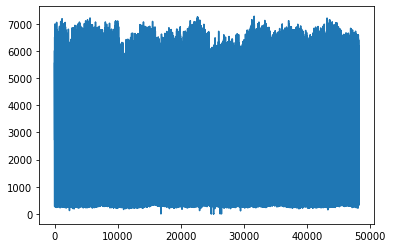

In [ ]:
plt.plot(y)

In [ ]:
TIME_STEPS = 256

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)
y = pd.DataFrame(y)
train_dataset = create_sequences(y)
print("Training input shape: ", train_dataset.shape)
x_train = train_dataset

Training input shape:  (47948, 256, 1)


In [ ]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))

        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(params=w, ids=encoding_indices)

In [ ]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance

        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss

        return recon_loss + loss #* beta
    return vq_vae_loss

In [ ]:
# Hyper Parameters.
epochs = 100 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           1024      
____________________________________________________________

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43153 samples, validate on 4795 samples
Epoch 1/100
43153/43153 [==============================] - 19s 429us/sample - loss: 110857.5725 - val_loss: 4047.9062
Epoch 2/100
43153/43153 [==============================] - 1s 30us/sample - loss: 3699.2601 - val_loss: 617.8317
Epoch 3/100
43153/43153 [==============================] - 1s 30us/sample - loss: 1025.7635 - val_loss: 216.4591
Epoch 4/100
43153/43153 [==============================] - 1s 30us/sample - loss: 440.5863 - val_loss: 90.0407
Epoch 5/100
43153/43153 [==============================] - 1s 30us/sample - loss: 235.0276 - val_loss: 43.0506
Epoch 6/100
43153/43153 [==============================] - 1s 30us/sample - loss: 143.9327 - val_loss: 25.9962
Epoch 7/100
43153/43153 [==============================] - 1s 30us/sample - loss: 98.9887 - val_loss: 17.6211
Epoch 8/100
43153/43153 [==============================] - 1s 30us/sam

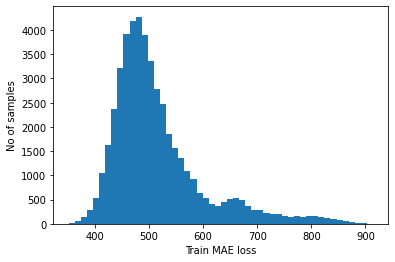

Reconstruction error threshold:  914.1453251261264


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.195844
dtype: float64

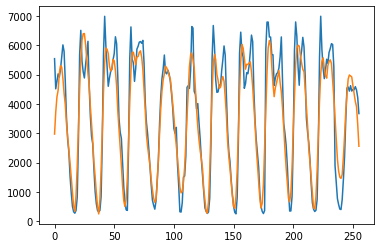

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[0][1:4]

array([[-0.63099134,  1.2197748 , -0.42585334, -1.2836142 ,  1.1345389 ,
        -0.9176674 ,  0.13979787, -0.9803497 , -0.15109363,  1.6901853 ,
         1.2598419 ,  1.0126879 ,  0.66867495,  0.99868965, -1.3129337 ,
         0.4692576 ],
       [-1.0993274 ,  1.9109478 , -0.7372137 , -2.0625443 ,  1.9948736 ,
        -1.5674993 ,  0.15471539, -1.6609755 , -0.21739729,  2.8360386 ,
         2.095867  ,  1.8751959 ,  1.2450051 ,  1.7674567 , -1.9092951 ,
         0.85405606],
       [-0.63099134,  1.2197748 , -0.42585334, -1.2836142 ,  1.1345389 ,
        -0.9176674 ,  0.13979787, -0.9803497 , -0.15109363,  1.6901853 ,
         1.2598419 ,  1.0126879 ,  0.66867495,  0.99868965, -1.3129337 ,
         0.4692576 ]], dtype=float32)

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0030897478433974785


In [ ]:
len(encoded_vectors)

38

In [ ]:
# Hyper Parameters.
epochs = 100 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           512       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 64, 16)            1808

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/100
43153/43153 [==============================] - 2s 47us/sample - loss: 131734.4920 - val_loss: 4311.6428
Epoch 2/100
43153/43153 [==============================] - 1s 31us/sample - loss: 5436.3793 - val_loss: 563.1288
Epoch 3/100
43153/43153 [==============================] - 1s 33us/sample - loss: 811.5264 - val_loss: 140.6369
Epoch 4/100
43153/43153 [==============================] - 1s 33us/sample - loss: 345.0512 - val_loss: 76.7714
Epoch 5/100
43153/43153 [==============================] - 1s 32us/sample - loss: 199.9622 - val_loss: 43.1095
Epoch 6/100
43153/43153 [==============================] - 1s 30us/sample - loss: 123.9800 - val_loss: 24.7555
Epoch 7/100
43153/43153 [==============================] - 1s 32us/sample - loss: 84.2627 - val_loss: 16.7065
Epoch 8/100
43153/43153 [==============================] - 1s 31us/sample - loss: 60.1888 - val_loss: 10.6923
Epoch 9/100
43153/43153 [==============================] 

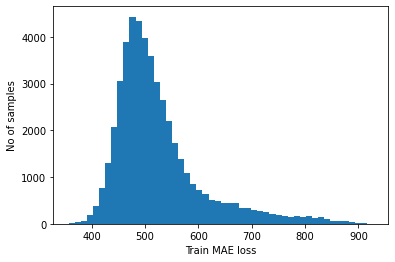

Reconstruction error threshold:  927.1128766536713


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.19832
dtype: float64

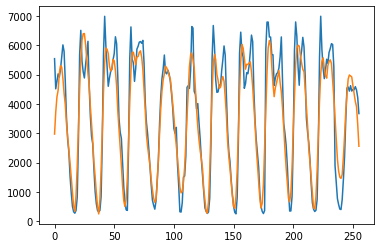

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[0][1:4]

array([[-0.53497463,  2.0451403 ,  0.7298565 , -1.0212505 , -0.8029017 ,
         0.5266003 , -0.47423413, -0.23506205, -0.27927014,  0.12029094,
         0.09007355, -0.435787  ,  0.33729   ,  0.09170138, -1.3185564 ,
        -1.8178179 ],
       [-0.9429215 ,  2.9477444 ,  1.0080082 , -1.5876288 , -1.0847106 ,
         0.72369295, -0.65318155, -0.37335315, -0.3588623 ,  0.10692618,
         0.18461108, -0.6969665 ,  0.54143256,  0.15989427, -1.8953216 ,
        -2.581297  ],
       [-0.9429215 ,  2.9477444 ,  1.0080082 , -1.5876288 , -1.0847106 ,
         0.72369295, -0.65318155, -0.37335315, -0.3588623 ,  0.10692618,
         0.18461108, -0.6969665 ,  0.54143256,  0.15989427, -1.8953216 ,
        -2.581297  ]], dtype=float32)

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0030897478433974785


In [ ]:
len(encoded_vectors)

26

In [ ]:
# Hyper Parameters.
epochs = 100 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 128, 32)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           256       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 64, 16)            1808

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/100
43153/43153 [==============================] - 2s 50us/sample - loss: 90721.3109 - val_loss: 2091.2764
Epoch 2/100
43153/43153 [==============================] - 1s 29us/sample - loss: 4500.0682 - val_loss: 776.9623
Epoch 3/100
43153/43153 [==============================] - 1s 28us/sample - loss: 1868.9694 - val_loss: 369.0095
Epoch 4/100
43153/43153 [==============================] - 1s 29us/sample - loss: 888.1643 - val_loss: 193.5243
Epoch 5/100
43153/43153 [==============================] - 1s 29us/sample - loss: 485.3019 - val_loss: 114.4152
Epoch 6/100
43153/43153 [==============================] - 1s 29us/sample - loss: 289.9489 - val_loss: 69.1510
Epoch 7/100
43153/43153 [==============================] - 1s 29us/sample - loss: 190.5512 - val_loss: 50.1442
Epoch 8/100
43153/43153 [==============================] - 1s 29us/sample - loss: 140.8239 - val_loss: 37.7709
Epoch 9/100
43153/43153 [============================

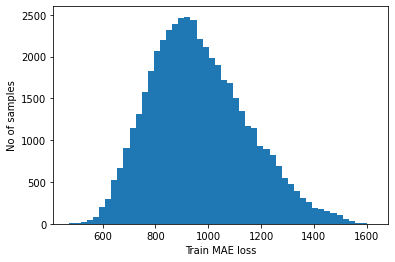

Reconstruction error threshold:  1624.08974789083


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.381134
dtype: float64

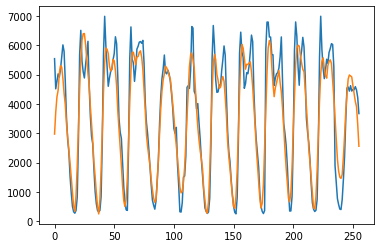

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[0][1:4]

array([[-0.25285333, -0.05365805,  0.17607573, -0.099897  , -0.25180474,
         0.08430558,  0.06882708, -0.34321642,  0.17759381, -0.17750667,
         0.05795278,  0.07615969,  0.24794747,  0.13690682, -0.10088916,
         0.00590668],
       [-0.25285333, -0.05365805,  0.17607573, -0.099897  , -0.25180474,
         0.08430558,  0.06882708, -0.34321642,  0.17759381, -0.17750667,
         0.05795278,  0.07615969,  0.24794747,  0.13690682, -0.10088916,
         0.00590668],
       [-0.25285333, -0.05365805,  0.17607573, -0.099897  , -0.25180474,
         0.08430558,  0.06882708, -0.34321642,  0.17759381, -0.17750667,
         0.05795278,  0.07615969,  0.24794747,  0.13690682, -0.10088916,
         0.00590668]], dtype=float32)

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0017003981420039814


In [ ]:
list(encoded_vectors.keys())[1]

(1.4209285,
 -0.8281848,
 -2.209581,
 0.42664766,
 0.58371687,
 1.2053066,
 -0.057914417,
 3.25972,
 -0.18539065,
 1.4851952,
 -0.60223424,
 -3.1354027,
 -0.89241415,
 0.16491379,
 0.83616513,
 0.0142040495)

In [ ]:
len(encoded_vectors)

16

In [ ]:
# Hyper Parameters.
epochs = 100 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 8 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 128, 32)           256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           128       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 64, 16)            1808

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/100
43153/43153 [==============================] - 3s 60us/sample - loss: 123087.9157 - val_loss: 2915.0124
Epoch 2/100
43153/43153 [==============================] - 1s 29us/sample - loss: 3900.7183 - val_loss: 560.6513
Epoch 3/100
43153/43153 [==============================] - 1s 29us/sample - loss: 1169.3341 - val_loss: 240.1851
Epoch 4/100
43153/43153 [==============================] - 1s 29us/sample - loss: 525.7752 - val_loss: 122.0930
Epoch 5/100
43153/43153 [==============================] - 1s 30us/sample - loss: 288.6819 - val_loss: 75.3761
Epoch 6/100
43153/43153 [==============================] - 1s 31us/sample - loss: 185.9200 - val_loss: 48.8544
Epoch 7/100
43153/43153 [==============================] - 1s 29us/sample - loss: 130.7004 - val_loss: 33.3554
Epoch 8/100
43153/43153 [==============================] - 1s 29us/sample - loss: 97.3982 - val_loss: 24.8749
Epoch 9/100
43153/43153 [=============================

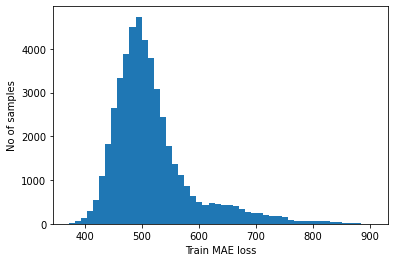

Reconstruction error threshold:  905.2094482183456


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.057674
dtype: float64

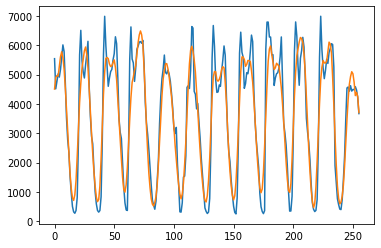

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[0][1:4]

array([[ 2.3535175 ,  1.525396  , -1.2520409 ,  1.7925855 ,  0.6066725 ,
         0.01466619, -1.9547595 ,  0.2904759 ,  0.9998301 ,  0.60870767,
        -2.2035553 ,  1.6382606 , -0.29236534,  0.6796401 , -1.0019153 ,
        -2.8156059 ],
       [ 2.3535175 ,  1.525396  , -1.2520409 ,  1.7925855 ,  0.6066725 ,
         0.01466619, -1.9547595 ,  0.2904759 ,  0.9998301 ,  0.60870767,
        -2.2035553 ,  1.6382606 , -0.29236534,  0.6796401 , -1.0019153 ,
        -2.8156059 ],
       [ 2.3535175 ,  1.525396  , -1.2520409 ,  1.7925855 ,  0.6066725 ,
         0.01466619, -1.9547595 ,  0.2904759 ,  0.9998301 ,  0.60870767,
        -2.2035553 ,  1.6382606 , -0.29236534,  0.6796401 , -1.0019153 ,
        -2.8156059 ]], dtype=float32)

In [ ]:
encoded_vectors = dictionary_encoding(intermediate_output)
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0009746184472461844


In [ ]:
list(encoded_vectors.keys())[1]

(2.3535175,
 1.525396,
 -1.2520409,
 1.7925855,
 0.6066725,
 0.014666191,
 -1.9547595,
 0.2904759,
 0.9998301,
 0.60870767,
 -2.2035553,
 1.6382606,
 -0.29236534,
 0.6796401,
 -1.0019153,
 -2.8156059)

In [ ]:
len(encoded_vectors)

8

In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 128, 128)          1024      
_________________________________________________________________
dropout_40 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 64, 64)            57408     
_________________________________________________________________
dropout_41 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 32, 32)            14368     
_________________________________________________________________
dropout_42 (Dropout)         (None, 32, 32)            0  

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/50
43153/43153 [==============================] - 10s 240us/sample - loss: 307.7355 - val_loss: 1.0374
Epoch 2/50
43153/43153 [==============================] - 7s 155us/sample - loss: 1.2551 - val_loss: 1.0362
Epoch 3/50
43153/43153 [==============================] - 6s 150us/sample - loss: 1.5302 - val_loss: 1.0173
Epoch 4/50
43153/43153 [==============================] - 6s 150us/sample - loss: 2.3184 - val_loss: 1.1256
Epoch 5/50
43153/43153 [==============================] - 6s 150us/sample - loss: 3.9177 - val_loss: 1.0079
Epoch 6/50
43153/43153 [==============================] - 6s 149us/sample - loss: 9.5834 - val_loss: 10.2640
Epoch 7/50
43153/43153 [==============================] - 6s 149us/sample - loss: 3.6284 - val_loss: 0.3632
Epoch 8/50
43153/43153 [==============================] - 6s 150us/sample - loss: 0.6029 - val_loss: 0.3117
Epoch 9/50
43153/43153 [==============================] - 6s 150us/sample - loss: 0

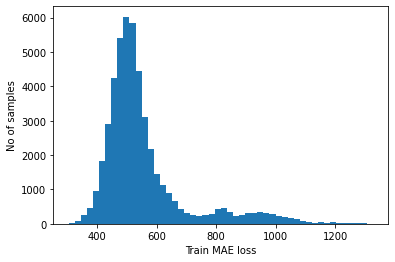

Reconstruction error threshold:  1327.1356582641602


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.018476
dtype: float64

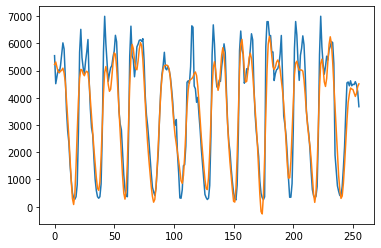

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
len(intermediate_output)

47948

In [ ]:
intermediate_output

In [ ]:
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0009746184472461844


In [ ]:
len(encoded_vectors)

10

In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 128, 128)          1024      
_________________________________________________________________
dropout_48 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 64, 64)            57408     
_________________________________________________________________
dropout_49 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 32, 32)            14368     
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 32)            0  

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/50
43153/43153 [==============================] - 10s 243us/sample - loss: 121.5453 - val_loss: 1.0220
Epoch 2/50
43153/43153 [==============================] - 6s 150us/sample - loss: 1.9298 - val_loss: 1.0109
Epoch 3/50
43153/43153 [==============================] - 6s 149us/sample - loss: 1.1197 - val_loss: 1.0067
Epoch 4/50
43153/43153 [==============================] - 6s 149us/sample - loss: 1.1181 - val_loss: 0.9968
Epoch 5/50
43153/43153 [==============================] - 7s 152us/sample - loss: 1.0514 - val_loss: 0.9953
Epoch 6/50
43153/43153 [==============================] - 7s 151us/sample - loss: 1.0278 - val_loss: 0.9993
Epoch 7/50
43153/43153 [==============================] - 7s 151us/sample - loss: 1.0282 - val_loss: 0.9946
Epoch 8/50
43153/43153 [==============================] - 6s 149us/sample - loss: 1.0140 - val_loss: 0.9940
Epoch 9/50
43153/43153 [==============================] - 7s 154us/sample - loss: 1.

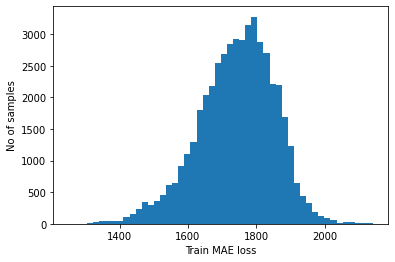

Reconstruction error threshold:  2141.5930042266846


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.011767
dtype: float64

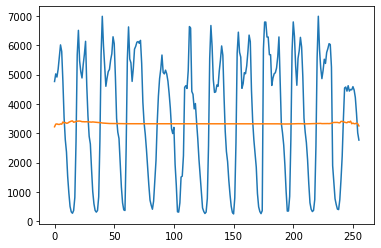

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[2])
plt.plot(x_train_pred[2])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[1][1]

array([ 1.0204285e-03,  1.1597524e-03,  1.8503407e-02,  2.1217377e-03,
        8.1256212e-04, -1.7745162e-03, -1.6717019e-04, -8.3827396e-04,
        1.7556140e-03, -4.7087664e-04, -2.2249457e-03, -6.9017062e-04,
        3.0996467e-04,  1.4505137e-03, -8.4714935e-04, -2.1899792e-03,
        2.1990729e-03,  1.4394504e-03,  7.2420901e-04, -2.5966938e-04,
        5.6922145e-02,  7.5948593e-04,  5.6420609e-02, -1.0132436e-03,
        1.6588692e-03, -5.5495105e-03,  7.0218230e-04,  7.9732906e-04,
       -5.1072213e-05, -4.7462927e-03, -5.8868207e-04, -1.2186137e-03],
      dtype=float32)

In [ ]:
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0009746184472461844


In [ ]:
len(encoded_vectors)

10

In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 256
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 8 # Length of embedding vectors.
num_embeddings = 8 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=128, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=64, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(x)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=64, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=128, kernel_size=7, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 128, 128)          1024      
_________________________________________________________________
dropout_52 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 64, 64)            57408     
_________________________________________________________________
dropout_53 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 32, 32)            14368     
_________________________________________________________________
dropout_54 (Dropout)         (None, 32, 32)            0  

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/50
43153/43153 [==============================] - 9s 213us/sample - loss: 2061.4758 - val_loss: 1.0851
Epoch 2/50
43153/43153 [==============================] - 4s 84us/sample - loss: 1.9956 - val_loss: 1.0625
Epoch 3/50
43153/43153 [==============================] - 4s 84us/sample - loss: 1.4799 - val_loss: 1.0409
Epoch 4/50
43153/43153 [==============================] - 4s 84us/sample - loss: 12.6040 - val_loss: 3.0376
Epoch 5/50
43153/43153 [==============================] - 4s 85us/sample - loss: 462.6444 - val_loss: 2.9707
Epoch 6/50
43153/43153 [==============================] - 4s 84us/sample - loss: 22.4094 - val_loss: 1.6346
Epoch 7/50
43153/43153 [==============================] - 4s 84us/sample - loss: 22.0131 - val_loss: 1.0208
Epoch 8/50
43153/43153 [==============================] - 4s 85us/sample - loss: 7.5721 - val_loss: 1.0172
Epoch 9/50
43153/43153 [==============================] - 4s 85us/sample - loss: 4.136

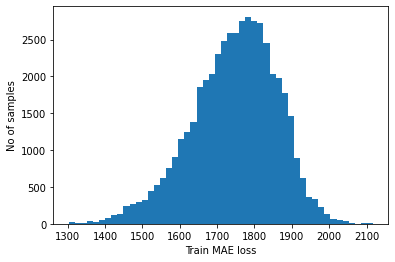

Reconstruction error threshold:  2117.3616514205933


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

In [ ]:
difference_mean/original_mean

0    0.379455
dtype: float64

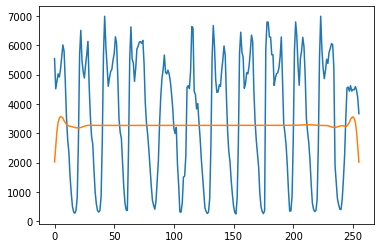

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
intermediate_output[:5]

In [ ]:
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(y)
print("Compression: ", embedded_size/original_size)

Compression:  0.0009746184472461844


In [ ]:
|